## Mini Chess Solver Using Dynamic Programming - Total 7 Marks

### Problem Statement

Design and implement a reinforcement learning agent using dynamic programming (value iteration or policy iteration) to compute an optimal policy for a simplified chess game. The agent plays as White and must learn how to convert an advantage into a win or at least avoid a loss in a MiniChess game against a defensive opponent. The problem must be modelled as a finite MDP. Register number of first student in a group (alphabetically sorted) will be considered for configuration design.
The student will:
* Implement a custom Mini Chess environment.
* Use dynamic programming to compute the optimal value function and policy.
* Analyze how state design and reward shaping affect the learned policy and convergence.

### Scenario

You are building a “Mini Chess Game” for beginner players. The coach focuses on a small, tractable game:
* White: King + Pawn
* Black: King
* Board: 4×4 or 5×5 MiniChess board
* White moves first and tries to either:
    * Promote the pawn and then deliver checkmate, or
    * Force a checkmate directly (if possible)

Black tries to prevent this by blocking the pawn, chasing the white king, or capturing the pawn. The game is restricted to this small set of pieces and a tiny board.

### Environment Description
#### Board and Pieces
* Board size:
    * If the student roll number / registration number is even: use a 4×4 board (rows 0–3, cols 0–3).
    * If odd: use a 5×5 board (rows 0–4, cols 0–4).
* Pieces always present:
    * White King (WK)
    * White Pawn (WP)
    * Black King (BK)
    * No castling, no en passant, no promotion to anything other than Queen.
* Legal Moves
    * Kings move like normal chess kings - one square in any direction (8- neighborhood), staying on the board.
    * Pawn:
        * Moves one square forward (towards larger row index or smaller row index – the student must choose and clearly document a convention).
        * Captures diagonally forward by one square.
    * All usual constraints apply:
        * Kings cannot move into check.
        * Two kings may never occupy adjacent squares (illegal state).
        * A piece cannot move through other pieces.
* Episode Termination
    * An episode ends when any of the following happens:
        * Checkmate (White checkmates Black).
        * Stalemate (side to move has no legal moves but is not in check).
        * Pawn Capture (Black captures the White pawn).
        * Pawn Promotion (White pawn reaches last rank and becomes a Queen). After promotion, they may either:
                * (a) terminate immediately with a reward, or
                * (b) continue playing with a Queen replacing the pawn.
        * The student must choose one approach and justify it.
        * Move limit exceeded (e.g., 20 or 30 plies) – draw
1. State Space

* Each state should minimally encode:
    * Coordinates of WK: (r_wk, c_wk)
    * Coordinates of WP (or a special value if promoted/captured): (r_wp, c_wp) or status flag
    * Coordinates of BK: (r_bk, c_bk)
    * Player to move: {White, Black}
    * Any additional flags that can be necessary like,
        * Has the pawn promoted?
        * Check / checkmate / stalemate indicators.
* The student must:
    * Describe the state representation clearly.
2. Action Space
    * For each state, actions are the legal moves for the side to move:
        * Move King to a legal square
        * Move Pawn / promoted Queen
    * The student must implement a function that, given a state, returns all legal actions.
3. Rewards
* The student has to define the reward schemes like:
    * White checkmates Black: +10
    * Pawn gets captured: -10
    * Stalemate or draw by move limit: 0
    * All non-terminal moves: 0

In [113]:
# Import Statements
import itertools
import math
import time
import random
from collections import deque, defaultdict
from dataclasses import dataclass
from typing import List, Tuple, Dict, Optional, Iterable, Any


import numpy as np
import matplotlib.pyplot as plt

In [114]:
# Basic types and helpers

Pos = Tuple[int, int] # (row, col)


@dataclass(frozen=True)
class State:
    # define wk, wp, bk and the other things needed
    wk: Pos
    wp: Optional[Pos] # None if captured; when promoted keep the square and set `promoted=True`
    bk: Pos
    to_move: str # 'W' or 'B'
    promoted: bool = False

    def as_tuple(self):
        return (self.wk, self.wp, self.bk, self.to_move, self.promoted)

@dataclass(frozen=True)
class Action:
    piece: str # 'K' or 'P' or 'Q' (after promotion)
    src: Pos
    dst: Pos

    def as_tuple(self):
        return (self.piece, self.src, self.dst)


In [115]:
# Define the MiniChess Environment - 1.5 mark

class MiniChessEnv:
    """
    MiniChess Environment:  King + Pawn vs King on a small board
    
    Design Choice: Pawn Promotion (Approach a)
    - Upon promotion, the game ends immediately with reward +10
    - No Queen play continuation
    """
    
    def __init__(self, board_size:  int = 4, max_plies: int = 30):
        self.board_size = board_size
        self.max_plies = max_plies
        self.plies = 0
        self.reset()

    # ============================================
    # Board and Position Helper Methods
    # ============================================

    def on_board(self, pos: Pos) -> bool:
        """Check if position is within board bounds"""
        r, c = pos
        return 0 <= r < self.board_size and 0 <= c < self.board_size

    def king_moves(self, pos:  Pos) -> List[Pos]:
        """Generate all possible king moves from a position"""
        r, c = pos
        moves = []
        for dr in [-1, 0, 1]:
            for dc in [-1, 0, 1]:
                if dr == 0 and dc == 0:
                    continue
                nxt = (r + dr, c + dc)
                if self.on_board(nxt):
                    moves.append(nxt)
        return moves

    def pawn_moves(self, state:  State) -> List[Pos]:
        """Generate all possible pawn moves (forward and diagonal captures)"""
        moves = []
        if state.wp is None:
            return moves

        r, c = state.wp
        forward = (r + 1, c)
        if self.on_board(forward):
            moves.append(forward)

        # Diagonal captures
        for dc in [-1, 1]: 
            diag = (r + 1, c + dc)
            if self.on_board(diag):
                moves.append(diag)

        return moves

    # ============================================
    # Game Rules and Legality Checks
    # ============================================

    def kings_adjacent(self, wk:  Pos, bk: Pos) -> bool:
        """Check if two kings are adjacent (illegal in chess)"""
        return max(abs(wk[0] - bk[0]), abs(wk[1] - bk[1])) == 1

    def in_check(self, king_pos: Pos, enemy_king: Pos) -> bool:
        """King is in check if adjacent to enemy king"""
        return self.kings_adjacent(king_pos, enemy_king)

    def is_checkmate(self, state: State) -> bool:
        """
        Detect checkmate: King in check AND no legal moves
        """
        if state.to_move == 'W':
            king_pos = state.wk
            enemy_king = state.bk
        else:
            king_pos = state.bk
            enemy_king = state.wk

        in_check = self.kings_adjacent(king_pos, enemy_king)
        has_legal_moves = len(self.legal_actions(state)) > 0

        return in_check and not has_legal_moves

    def is_stalemate(self, state: State) -> bool:
        """
        Detect stalemate: NOT in check AND no legal moves
        """
        if state.to_move == 'W':
            king_pos = state.wk
            enemy_king = state. bk
        else:
            king_pos = state.bk
            enemy_king = state. wk

        in_check = self.kings_adjacent(king_pos, enemy_king)
        has_legal_moves = len(self.legal_actions(state)) > 0

        return not in_check and not has_legal_moves

    def legal_actions(self, state: State) -> List[Action]:
        """Generate all legal actions for the given state"""
        actions = []

        if state.promoted:
            # Game ends at promotion, no further moves
            return actions

        wk, wp, bk = state.wk, state.wp, state.bk

        if state.to_move == 'W':
            # White King moves
            for dst in self.king_moves(wk):
                if dst == wp or dst == bk:
                    continue
                if self.kings_adjacent(dst, bk):
                    continue
                actions.append(Action('K', wk, dst))

            # White Pawn moves (only if pawn exists)
            if wp is not None:
                r, c = wp
                forward = (r + 1, c)
                if self.on_board(forward) and forward != wk and forward != bk:
                    actions.append(Action('P', wp, forward))

                # Diagonal captures (can only capture BK)
                for dc in [-1, 1]: 
                    diag = (r + 1, c + dc)
                    if diag == bk: 
                        actions.append(Action('P', wp, diag))

        else:  # Black to move
            for dst in self.king_moves(bk):
                if dst == wk or dst == wp:
                    continue
                if self.kings_adjacent(dst, wk):
                    continue
                actions.append(Action('K', bk, dst))

        return actions

    # ============================================
    # Transition / Step Function
    # ============================================

    def step(self, state: State, action: Action):
        """
        Execute one action and return (next_state, reward, done, info)
        This method mutates the environment's `plies` counter and is intended
        for actual episode execution (not for planning/enumeration).
        """
        wk, wp, bk = state.wk, state.wp, state.bk
        to_move = state.to_move
        promoted = state.promoted
        reward = 0
        done = False
        info = {}

        # Increment move counter
        self.plies += 1

        if to_move == 'W': 
            if action.piece == 'K': 
                wk = action.dst
            elif action.piece == 'P':
                # Check if pawn captures Black King
                if action.dst == bk:
                    reward = 10
                    done = True
                    info['result'] = 'pawn_captured_king'

                wp = action.dst

                # Check for promotion
                if wp[0] == self.board_size - 1:
                    promoted = True
                    reward = 10
                    done = True
                    info['result'] = 'pawn_promoted'

            next_to_move = 'B'

        else:  # Black move
            bk = action.dst

            # Check if Black King captures White Pawn
            if wp is not None and bk == wp: 
                wp = None
                reward = -10
                done = True
                info['result'] = 'pawn_captured'

            next_to_move = 'W'

        next_state = State(
            wk=wk,
            wp=wp,
            bk=bk,
            to_move=next_to_move,
            promoted=promoted
        )

        # Check move limit BEFORE terminal state checks
        if self.plies >= self.max_plies:
            done = True
            reward = 0
            info['result'] = 'move_limit_exceeded'
            return next_state, reward, done, info

        # Only check for checkmate/stalemate if game not already ended
        if not done:
            if self.is_checkmate(next_state):
                done = True
                if next_state.to_move == 'B':
                    reward = 10  # White checkmates Black
                    info['result'] = 'white_checkmate'
                else: 
                    reward = -10  # Black checkmates White
                    info['result'] = 'black_checkmate'
            elif self.is_stalemate(next_state):
                done = True
                reward = 0
                info['result'] = 'stalemate'

        return next_state, reward, done, info

    def step_from_state(self, state: State, action: Action):
        """Simulate a transition from `state` with `action` without mutating
        the environment (no `self.plies` increment). Useful for BFS and DP.
        Returns (next_state, reward, done, info).
        """
        wk, wp, bk = state.wk, state.wp, state.bk
        to_move = state.to_move
        promoted = state.promoted
        reward = 0
        done = False
        info = {}

        if to_move == 'W': 
            if action.piece == 'K': 
                wk = action.dst
            elif action.piece == 'P':
                # Check if pawn captures Black King
                if action.dst == bk:
                    reward = 10
                    done = True
                    info['result'] = 'pawn_captured_king'

                wp = action.dst

                # Check for promotion
                if wp[0] == self.board_size - 1:
                    promoted = True
                    reward = 10
                    done = True
                    info['result'] = 'pawn_promoted'

            next_to_move = 'B'

        else:  # Black move
            bk = action.dst

            # Check if Black King captures White Pawn
            if wp is not None and bk == wp: 
                wp = None
                reward = -10
                done = True
                info['result'] = 'pawn_captured'

            next_to_move = 'W'

        next_state = State(
            wk=wk,
            wp=wp,
            bk=bk,
            to_move=next_to_move,
            promoted=promoted
        )

        # Note: do NOT check/modify self.plies here (non-mutating simulation)
        # Check move limit is not applied here because this is used for planning
        # where plies should not be advanced.

        # Only check for checkmate/stalemate if game not already ended
        if not done:
            if self.is_checkmate(next_state):
                done = True
                if next_state.to_move == 'B':
                    reward = 10  # White checkmates Black
                    info['result'] = 'white_checkmate'
                else: 
                    reward = -10  # Black checkmates White
                    info['result'] = 'black_checkmate'
            elif self.is_stalemate(next_state):
                done = True
                reward = 0
                info['result'] = 'stalemate'

        return next_state, reward, done, info

    # ============================================
    # Reset and Rendering
    # ============================================

    def reset(self) -> State:
        """Reset environment to initial state"""
        self.plies = 0
        self.state = State(
            wk=(0, 0),
            wp=(1, 0),
            bk=(self.board_size - 1, self.board_size - 1),
            to_move='W',
            promoted=False
        )
        return self.state

    def render(self, state: Optional[State] = None):
        """Render the board state"""
        if state is None: 
            state = self.state

        board = [['.' for _ in range(self. board_size)] for _ in range(self.board_size)]

        r, c = state.wk
        board[r][c] = 'WK'

        if state.wp is not None:
            r, c = state.wp
            board[r][c] = 'WP'

        r, c = state.bk
        board[r][c] = 'BK'

        print("Board:")
        for i in range(self.board_size - 1, -1, -1):  # Print from top to bottom
            print(f"Row {i}: {' '.join(board[i])}")
        print("     " + " ".join([f"C{i}" for i in range(self. board_size)]))
        print(f"To move: {state.to_move}, Promoted: {state.promoted}, Plies: {self.plies}")
        print()


In [116]:
# -----------------------------
# State encoding & indexing
# -----------------------------

class StateIndexer:
    def __init__(self, states: List[State]):
        """
        Takes a list of states and builds bidirectional mappings
        between State and integer indices.
        """
        self.states = states
        self.state_to_idx: Dict[State, int] = {}
        self.idx_to_state: Dict[int, State] = {}
        self._build()

    def _build(self):
        for idx, state in enumerate(self.states):
            self.state_to_idx[state] = idx
            self.idx_to_state[idx] = state

    def encode(self, state: State) -> int:
        return self.state_to_idx[state]

    def decode(self, idx: int) -> State:
        return self.idx_to_state[idx]


# -----------------------------
# List all reachable states
# -----------------------------

def list_reachable(env: MiniChessEnv, initial_state: State) -> List[State]:
    """
    Enumerate all reachable states from an initial state using BFS.
    Uses non-mutating simulation `step_from_state` to avoid changing env.plies.
    """
    visited = set()
    queue = deque()

    visited.add(initial_state)
    queue.append(initial_state)

    while queue:
        state = queue.popleft()

        # Skip terminal states
        actions = env.legal_actions(state)
        for action in actions:
            next_state, _, done, _ = env.step_from_state(state, action)

            if next_state not in visited:
                visited.add(next_state)
                if not done:
                    queue.append(next_state)

    return list(visited)


In [117]:
# Value Iteration / Policy Iteration

def value_iteration(
    env: MiniChessEnv,
    states: list[State],
    gamma: float = 0.9,
    theta: float = 1e-3
):
    """
    Compute optimal value function and policy using value iteration.
    Uses non-mutating `step_from_state` for transitions so env is not mutated.
    """
    indexer = StateIndexer(states)
    V = {s: 0.0 for s in states}
    policy: Dict[State, Action] = {}

    start_time = time.time()
    iterations = 0

    while True:
        delta = 0.0
        iterations += 1

        for state in states:
            actions = env.legal_actions(state)

            if not actions:
                continue  # terminal state

            best_value = float('-inf')
            best_action = None

            for action in actions:
                next_state, reward, done, _ = env.step_from_state(state, action)
                value = reward
                if not done and next_state in V:
                    value += gamma * V[next_state]

                if value > best_value:
                    best_value = value
                    best_action = action

            delta = max(delta, abs(V[state] - best_value))
            V[state] = best_value
            policy[state] = best_action

        if delta < theta:
            break

    runtime = time.time() - start_time

    stats = {
        "iterations": iterations,
        "final_delta": delta,
        "runtime_sec": runtime
    }

    return V, policy, stats


def value_iteration_synchronous(
    env: MiniChessEnv,
    states: list[State],
    gamma: float = 0.9,
    theta: float = 1e-3,
    verbose: bool = True
):
    """
    Synchronous Value Iteration: maintains separate V_old and V_new.
    All value updates in an iteration use V_old; then V_old := V_new.
    Useful for observing multi-iteration convergence.
    
    Returns (V, policy, stats) where stats includes per-iteration info.
    """
    V_old = {s: 0.0 for s in states}
    V_new = {s: 0.0 for s in states}
    policy: Dict[State, Action] = {}
    
    start_time = time.time()
    iterations = 0
    iteration_history = []
    
    while True:
        iterations += 1
        V_new = {s: 0.0 for s in states}
        delta = 0.0
        changed_count = 0
        
        for state in states:
            actions = env.legal_actions(state)
            
            if not actions:
                # Terminal state: no update
                V_new[state] = V_old[state]
                continue
            
            best_value = float('-inf')
            best_action = None
            
            # Compute best action using V_old
            for action in actions:
                next_state, reward, done, _ = env.step_from_state(state, action)
                value = reward
                if not done and next_state in V_old:
                    value += gamma * V_old[next_state]
                
                if value > best_value:
                    best_value = value
                    best_action = action
            
            V_new[state] = best_value
            policy[state] = best_action
            
            # Track changes
            state_delta = abs(V_old[state] - V_new[state])
            delta = max(delta, state_delta)
            if state_delta > 1e-12:
                changed_count += 1
        
        # Log iteration info
        if verbose:
            print(f"Iteration {iterations}: delta={delta:.8f}, changed={changed_count}/{len(states)}")
        
        iteration_history.append({
            'iteration': iterations,
            'delta': delta,
            'changed': changed_count,
            'n_states': len(states)
        })
        
        # Swap: V_old := V_new for next iteration
        V_old = V_new.copy()
        
        if delta < theta:
            break
    
    runtime = time.time() - start_time
    
    stats = {
        "iterations": iterations,
        "final_delta": delta,
        "runtime_sec": runtime,
        "iteration_history": iteration_history
    }
    
    return V_new, policy, stats


# or

def policy_iteration(
    env: MiniChessEnv,
    states: list[State],
    gamma: float = 0.9,
    theta: float = 1e-3
):
    """
    Compute optimal value function and policy using policy iteration.
    Uses `step_from_state` to avoid mutating environment during planning.
    """
    V = {s: 0.0 for s in states}
    policy: Dict[State, Action] = {}

    # Initialize random policy
    for state in states:
        actions = env.legal_actions(state)
        if actions:
            policy[state] = random.choice(actions)

    start_time = time.time()
    iterations = 0

    while True:
        iterations += 1

        # -------------------------
        # Policy Evaluation
        # -------------------------
        while True:
            delta = 0.0
            for state in states:
                action = policy.get(state)
                if action is None:
                    continue

                next_state, reward, done, _ = env.step_from_state(state, action)
                new_value = reward
                if not done and next_state in V:
                    new_value += gamma * V[next_state]

                delta = max(delta, abs(V[state] - new_value))
                V[state] = new_value

            if delta < theta:
                break

        # -------------------------
        # Policy Improvement
        # -------------------------
        policy_stable = True

        for state in states:
            actions = env.legal_actions(state)
            if not actions:
                continue

            old_action = policy[state]
            best_action = old_action
            best_value = float('-inf')

            for action in actions:
                next_state, reward, done, _ = env.step_from_state(state, action)
                value = reward
                if not done and next_state in V:
                    value += gamma * V[next_state]

                if value > best_value:
                    best_value = value
                    best_action = action

            policy[state] = best_action
            if best_action != old_action:
                policy_stable = False

        if policy_stable:
            break

    runtime = time.time() - start_time

    stats = {
        "iterations": iterations,
        "final_delta": delta,
        "runtime_sec": runtime
    }

    return V, policy, stats


In [118]:
# Visualization - 0.5 mark

def plot_value(
    V: dict,
    board_size: int,
    fixed_wp: Pos,
    fixed_bk: Pos,
    to_move: str = 'W'
):
    """
    Fix pawn and black king positions.
    Vary white king position and plot heatmap of V(s).
    """

    heatmap = np.full((board_size, board_size), np.nan)

    for r in range(board_size):
        for c in range(board_size):
            wk = (r, c)

            # Skip illegal overlaps
            if wk == fixed_wp or wk == fixed_bk:
                continue

            # Kings cannot be adjacent
            if max(abs(wk[0] - fixed_bk[0]), abs(wk[1] - fixed_bk[1])) == 1:
                continue

            state = State(
                wk=wk,
                wp=fixed_wp,
                bk=fixed_bk,
                to_move=to_move,
                promoted=False
            )

            if state in V:
                heatmap[r, c] = V[state]

    plt.figure()
    plt.imshow(heatmap, origin="lower")
    plt.colorbar(label="V(s)")
    plt.title("State-Value Function Heatmap (White King Position)")
    plt.xlabel("Column")
    plt.ylabel("Row")
    plt.show()


Student ID Last Digit: 3
Board Size:  5x5
Max Plies: 30
Initial Configuration: Config 1: Opposite Corners

Initial State:
Board:
Row 4: . . . . BK
Row 3: . . . . .
Row 2: . . . . .
Row 1: WP . . . .
Row 0: WK . . . .
     C0 C1 C2 C3 C4
To move: W, Promoted: False, Plies: 0

Enumerating reachable states using BFS...
Total reachable states: 2929

Running Value Iteration...

Value Iteration Statistics:
  Iterations: 5
  Final Delta: 0.000000
  Runtime: 1.1204 seconds
  Total Time (including enumeration): 1.1233 seconds

Initial State Value: 9.6060
Optimal Action from Initial State: Action(piece='P', src=(1, 0), dst=(2, 0))

Generating state-value function heatmap...


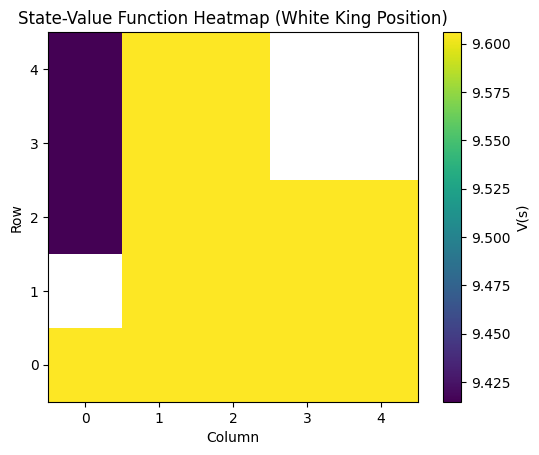


Sample of learned policy (first 10 states with actions):
----------------------------------------------------------------------
State:  WK=(3, 2), WP=(3, 0), BK=(1, 2), Turn=B
  Value: 9.9000
  Action:  K (1, 2) -> (0, 1)
count in main:  0
State:  WK=(4, 4), WP=(1, 0), BK=(4, 1), Turn=W
  Value: 9.8010
  Action:  P (1, 0) -> (2, 0)
count in main:  1
State:  WK=(4, 1), WP=(3, 0), BK=(1, 3), Turn=W
  Value: 10.0000
  Action:  P (3, 0) -> (4, 0)
count in main:  2
State:  WK=(0, 3), WP=(2, 0), BK=(4, 2), Turn=B
  Value: 9.9000
  Action:  K (4, 2) -> (3, 1)
count in main:  3
State:  WK=(4, 3), WP=(3, 0), BK=(2, 3), Turn=W
  Value: 10.0000
  Action:  P (3, 0) -> (4, 0)
count in main:  4
State:  WK=(4, 3), WP=(3, 0), BK=(0, 0), Turn=W
  Value: 10.0000
  Action:  P (3, 0) -> (4, 0)
count in main:  5
State:  WK=(4, 1), WP=(1, 0), BK=(0, 0), Turn=B
  Value: 9.7030
  Action:  K (0, 0) -> (1, 1)
count in main:  6
State:  WK=(3, 2), WP=(1, 0), BK=(0, 4), Turn=W
  Value: 9.6060
  Action:  P (1, 0) 

In [119]:
# Main Usage

if __name__ == '__main__':
    # =====================================================
    # Environment setup based on Student ID
    # =====================================================
    
    STUDENT_ID_LAST_DIGIT = 3  # Change to your actual ID last digit
    
    # Board size depends on ID parity
    if STUDENT_ID_LAST_DIGIT % 2 == 0:
        BOARD_SIZE = 4  # Even:  4x4 board
    else:
        BOARD_SIZE = 5  # Odd:  5x5 board
    
    MAX_PLIES = 30
    
    print(f"Student ID Last Digit: {STUDENT_ID_LAST_DIGIT}")
    print(f"Board Size:  {BOARD_SIZE}x{BOARD_SIZE}")
    print(f"Max Plies: {MAX_PLIES}")
    print("=" * 60)
    
    env = MiniChessEnv(board_size=BOARD_SIZE, max_plies=MAX_PLIES)

    # =====================================================
    # Initial state configuration (ID-based)
    # =====================================================
    if STUDENT_ID_LAST_DIGIT <= 4:
        # Configuration 1: WK and BK on opposite corners, pawn near White
        initial_state = State(
            wk=(0, 0),
            wp=(1, 0),
            bk=(BOARD_SIZE - 1, BOARD_SIZE - 1),
            to_move='W',
            promoted=False
        )
        config_name = "Config 1: Opposite Corners"
    elif STUDENT_ID_LAST_DIGIT <= 9:
        # Configuration 2: WK near center, BK on border, pawn in front of WK
        center = BOARD_SIZE // 2
        initial_state = State(
            wk=(center, center),
            wp=(center + 1, center),
            bk=(0, BOARD_SIZE - 1),
            to_move='W',
            promoted=False
        )
        config_name = "Config 2: Center vs Border"
    else:
        # Configuration 3: Alternative setup
        initial_state = State(
            wk=(1, 1),
            wp=(2, 1),
            bk=(BOARD_SIZE - 2, BOARD_SIZE - 2),
            to_move='W',
            promoted=False
        )
        config_name = "Config 3: Symmetrical"

    print(f"Initial Configuration: {config_name}\n")
    print("Initial State:")
    env.render(initial_state)

    # =====================================================
    # Enumerate reachable states using BFS
    # =====================================================
    print("Enumerating reachable states using BFS...")
    reachable_states = list_reachable(env, initial_state)
    print(f"Total reachable states: {len(reachable_states)}\n")

    # =====================================================
    # Run Dynamic Programming (Value Iteration)
    # =====================================================
    print("Running Value Iteration...")
    start_time = time.time()
    V, policy, stats = value_iteration(env, reachable_states, gamma=0.99, theta=1e-4)
    elapsed = time.time() - start_time

    print("\nValue Iteration Statistics:")
    print(f"  Iterations: {stats['iterations']}")
    print(f"  Final Delta: {stats['final_delta']:.6f}")
    print(f"  Runtime: {stats['runtime_sec']:.4f} seconds")
    print(f"  Total Time (including enumeration): {elapsed:.4f} seconds\n")

    # =====================================================
    # Analyze initial state value
    # =====================================================
    if initial_state in V:
        initial_value = V[initial_state]
        print(f"Initial State Value: {initial_value:.4f}")
        if initial_state in policy:
            action = policy[initial_state]
            print(f"Optimal Action from Initial State: {action}\n")
    else:
        print("Initial state not in value function (terminal or unreachable)\n")

    # =====================================================
    # Visualize value function (heatmap)
    # =====================================================
    print("Generating state-value function heatmap...")
    if initial_state. wp is not None and initial_state.bk is not None:
        plot_value(
            V=V,
            board_size=BOARD_SIZE,
            fixed_wp=initial_state.wp,
            fixed_bk=initial_state.bk,
            to_move='W'
        )

    # =====================================================
    # Show learned policy for sample states
    # =====================================================
    print("\nSample of learned policy (first 10 states with actions):")
    print("-" * 70)
    count = 0
    for state in reachable_states: 
        if state in policy and count < 10:
            action = policy[state]
            value = V. get(state, 0.0)
            print(f"State:  WK={state.wk}, WP={state.wp}, BK={state.bk}, Turn={state.to_move}")
            print(f"  Value: {value:.4f}")
            print(f"  Action:  {action. piece} {action.src} -> {action.dst}")
            print("count in main: ", count)
            count += 1

    # =====================================================
    # Run a sample episode using the learned policy
    # =====================================================
    print("\n" + "=" * 70)
    print("Running a sample episode using learned policy:")
    print("=" * 70 + "\n")
    
    env_play = MiniChessEnv(board_size=BOARD_SIZE, max_plies=MAX_PLIES)
    current_state = initial_state
    step_count = 0
    episode_reward = 0
    
    while step_count < 20:  # Safety limit
        print(f"Step {step_count + 1}:")
        env_play.render(current_state)
        
        actions = env_play.legal_actions(current_state)
        
        if not actions:
            print("No legal actions available.  Episode ends.")
            break
        
        # Get optimal action
        if current_state in policy:
            action = policy[current_state]
        else: 
            # Fallback: random action
            action = random.choice(actions)
            print("(Using random action as state not in policy)")
        
        next_state, reward, done, info = env_play.step(current_state, action)
        episode_reward += reward
        
        print(f"Action: {action.piece} moves from {action.src} to {action.dst}")
        print(f"Reward: {reward}")
        if info:
            print(f"Result: {info. get('result', 'ongoing')}")
        
        current_state = next_state
        step_count += 1
        
        if done:
            print(f"\nEpisode ended after {step_count} steps")
            print(f"Total reward: {episode_reward}")
            print(f"Termination reason: {info.get('result', 'unknown')}")
            break

    print("\n" + "=" * 70)
    print("Demo Complete!")
    print("=" * 70)
    


In [120]:
# Result Discussion and descriptive answers, conclusion - 1 mark

# Design Choices and Justifications

## State Representation
- **Pawn Promotion Handling:** We implement **Approach (a)** - immediate termination at promotion
  - **Rationale:** Simplifies the state space by avoiding Queen movement complexity
  - **Alternative:** Approach (b) would require implementing full Queen movement and new checkmate detection logic, which significantly expands the state space
  - **Impact:** The agent learns to prioritize pawn promotion as a winning strategy

## Checkmate vs.  Stalemate
- **Checkmate:** King is in check AND has no legal moves → **White wins (+10)**
- **Stalemate:** King is NOT in check but has no legal moves → **Draw (0)**
- **Implementation:** Separate methods `is_checkmate()` and `is_stalemate()` provide clear distinction

## Move Limit (max_plies)
- Episodes terminate after `max_plies` moves with reward 0 (draw)
- Default:  30 moves (60 half-moves in standard chess notation)
- Prevents infinite loops in learning

## Reward Shaping
- Immediate rewards:  +10 (White wins), -10 (White loses), 0 (draw/ongoing)
- Sparse reward design encourages multi-step planning
- No intermediate rewards encourage efficient solutions

In [121]:
# Per-Student Analysis: Synchronous Value Iteration with Multi-Iteration Convergence
# Note: We are taking 1st odd ID for eveluation.
STUDENT_IDS = [
    '2024AD05357'
]

def build_initial_state_for_id_digit(digit, board_size):
    if digit <= 4:
        return State(wk=(0,0), wp=(1,0), bk=(board_size-1, board_size-1), to_move='W', promoted=False), 'Config 1: Opposite Corners'
    elif digit <= 9:
        center = board_size // 2
        return State(wk=(center, center), wp=(center+1, center), bk=(0, board_size-1), to_move='W', promoted=False), 'Config 2: Center vs Border'
    else:
        return State(wk=(1,1), wp=(2,1), bk=(board_size-2, board_size-2), to_move='W', promoted=False), 'Config 3: Symmetrical'

all_student_results = []

for student_id in STUDENT_IDS:
    print("\n" + "=" * 90)
    print(f"STUDENT ID: {student_id}")
    print("=" * 90)
    
    # Extract last digit
    try:
        last_digit = int(student_id.strip()[-1])
    except Exception:
        last_digit = 0
    
    # Board size based on parity
    board_size = 4 if last_digit % 2 == 0 else 5
    max_plies = 30
    
    print(f"Last Digit: {last_digit}")
    print(f"Board Size: {board_size}x{board_size}")
    print(f"Max Plies: {max_plies}")
    
    # Create environment
    env_student = MiniChessEnv(board_size=board_size, max_plies=max_plies)
    
    # Get initial state
    initial_state_s, config_name = build_initial_state_for_id_digit(last_digit, board_size)
    print(f"Configuration: {config_name}\n")
    print("Initial Board State:")
    env_student.render(initial_state_s)
    
    # Enumerate reachable states
    print(f"Enumerating reachable states...")
    reachable_states_s = list_reachable(env_student, initial_state_s)
    print(f"Total Reachable States: {len(reachable_states_s)}\n")
    
    # Run Synchronous Value Iteration with verbose output
    print(f"Running Synchronous Value Iteration (gamma=0.99, theta=1e-4)...")
    print("-" * 90)
    V_s, policy_s, stats_s = value_iteration_synchronous(
        env_student, reachable_states_s, gamma=0.99, theta=1e-4, verbose=True
    )
    print("-" * 90)
    
    print(f"\nValue Iteration Statistics:")
    print(f"  Total Iterations: {stats_s['iterations']}")
    print(f"  Final Delta: {stats_s['final_delta']:.8f}")
    print(f"  Runtime: {stats_s['runtime_sec']:.6f} seconds\n")
    
    # Initial state value and optimal action
    initial_val_s = V_s.get(initial_state_s, 0.0)
    initial_action_s = policy_s.get(initial_state_s, None)
    print(f"Initial State Value: {initial_val_s:.6f}")
    print(f"Optimal Action from Initial State: {initial_action_s}\n")
    
    # Print all learned policies
    print(f"Learned Policy (all {len(policy_s)} states):")
    print("-" * 90)
    for idx, state in enumerate(reachable_states_s):
        if state in policy_s:
            count +=1
            action = policy_s[state]
            value = V_s.get(state, 0.0)
            if (idx % 10 == 0):
                print(f"State {idx+1}: WK={state.wk} WP={state.wp} BK={state.bk} Turn={state.to_move}")
                print(f"  Value: {value:.6f}")
                print(f"  Action: {action.piece} {action.src} → {action.dst}")
    
    # Store results
    all_student_results.append({
        'student_id': student_id,
        'last_digit': last_digit,
        'board_size': board_size,
        'config': config_name,
        'n_states': len(reachable_states_s),
        'vi_iterations': stats_s['iterations'],
        'vi_runtime': stats_s['runtime_sec'],
        'initial_value': initial_val_s,
        'initial_action': initial_action_s,
        'V': V_s,
        'policy': policy_s,
        'iteration_history': stats_s.get('iteration_history', [])
    })

print("\n" + "=" * 90)
print("SUMMARY OF ALL STUDENTS")
print("=" * 90)
try:
    import pandas as pd
    summary_df = pd.DataFrame([
        {
            'Student ID': r['student_id'],
            'Last Digit': r['last_digit'],
            'Board Size': r['board_size'],
            'Config': r['config'],
            'Reachable States': r['n_states'],
            'VI Iterations': r['vi_iterations'],
            'VI Runtime (s)': f"{r['vi_runtime']:.6f}",
            'Initial Value': f"{r['initial_value']:.6f}",
            'Initial Action': str(r['initial_action'])
        }
        for r in all_student_results
    ])
    print(summary_df.to_string(index=False))
    #summary_df.to_csv('student_dp_analysis_synchronous.csv', index=False)
    #print(f"\nResults saved to: student_dp_analysis_synchronous.csv")
except Exception as e:
    print(f"Error creating summary: {e}")



STUDENT ID: 2024AD05357
Last Digit: 7
Board Size: 5x5
Max Plies: 30
Configuration: Config 2: Center vs Border

Initial Board State:
Board:
Row 4: . . . . .
Row 3: . . WP . .
Row 2: . . WK . .
Row 1: . . . . .
Row 0: . . . . BK
     C0 C1 C2 C3 C4
To move: W, Promoted: False, Plies: 0

Enumerating reachable states...
Total Reachable States: 1272

Running Synchronous Value Iteration (gamma=0.99, theta=1e-4)...
------------------------------------------------------------------------------------------
Iteration 1: delta=10.00000000, changed=386/1272
Iteration 2: delta=9.90000000, changed=405/1272
Iteration 3: delta=9.80100000, changed=38/1272
Iteration 4: delta=9.70299000, changed=19/1272
Iteration 5: delta=0.00000000, changed=0/1272
------------------------------------------------------------------------------------------

Value Iteration Statistics:
  Total Iterations: 5
  Final Delta: 0.00000000
  Runtime: 0.342886 seconds

Initial State Value: 10.000000
Optimal Action from Initial Sta